In [11]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
plt.rcParams.update({
    'text.latex.preamble': r'\usepackage{amsmath}',
    'text.usetex': True,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica']
})

from tqdm import tqdm,trange

In [2]:
def get_LJ_potential(P,sig=1,eps=1):
    x = P.T[0]
    y = P.T[1]
    
    X = np.tile(x,(x.shape[0],1))
    XT = X.T

    Y = np.tile(y,(y.shape[0],1))
    YT = Y.T
    
    r = np.sqrt((X - XT)**2 + (Y - YT)**2).flatten()
    r = r[r!=0]
    
    return np.sum(4*eps*((sig/r)**12 - (sig/r)**6))/2

In [3]:
def walk(config,h=1,freeze=None):
    step = h*(2*np.random.uniform(size=config.shape)-1)
    
    if freeze is not None:
        cond = np.tile(freeze,(2,1)).T
        step *= cond
    
    return config + step

In [4]:
def minimize(config,h=1,sig=1,eps=1,rtol=1e-3,atol=1e-10,max_iter=int(1e8),freeze=None,track=False):
    configs = [config]
    U = [get_LJ_potential(config)]
    
    for i in range(max_iter):
        new_config = walk(configs[-1],h,freeze)
        new_U = get_LJ_potential(new_config,sig,eps)
        
        if new_U > U[-1]:
            continue
            
        configs.append(new_config)
        U.append(new_U)

        adiff = np.abs(new_U - U[-2])
        rdiff = np.abs(adiff/U[-2])
        if adiff < atol:
            # print(i,'adiff',adiff)
            # print(U[-2],U[-1])
            # print(configs[-2])
            # print(configs[-2])
            break
        elif rdiff < rtol:
            # print(i,'rdiff',rdiff)
            # print(U[-2],U[-1])
            # print(configs[-2])
            # print(configs[-2])
            break
    
    if track:
        return np.array(configs),np.array(U)
    else:
        return configs[-1],U[-1]

In [5]:
def transform(P,a=np.array([0,0]),theta=0,origin=np.array([0,0])):
    R = np.array([
        [np.cos(theta),-np.sin(theta)],
        [np.sin(theta),np.cos(theta)]
    ])
    
    P_ = np.zeros(P.shape)
    for i in len(P):
        p = P[i]
        p = p + a
        p = R@(p - origin) + origin
        
        P_[i] = p
    
    return P_

# Method 1

In [6]:
def do_method1(h,L,N,track=False):
    P = L*np.random.uniform(size=(N,2))

    configs,U = [],[]
    for i in range(N):
        configs_,U_ = minimize(P,h,track=True,freeze=np.array([j==i for j in range(N)]))
        configs += list(configs_)
        U       += list(U_)

        P = configs_[-1]
    
    if track:
        return np.array(configs),np.array(U)
    else:
        return configs[-1],U[-1]

track one minimization

In [7]:
h = 0.2
L = 1
N = 3

configs,U = do_method1(h,L,N,track=True)

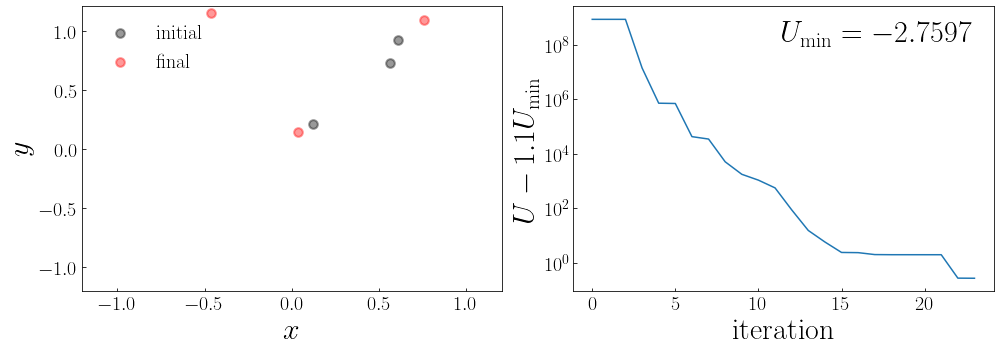

In [8]:
nrows,ncols=1,2
fig,ax=plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

x,y = configs[0].T
ax[0].scatter(x,y,marker='o',s=75,lw=2,color='k',alpha=0.4,edgecolor='k',label=r'$\rm initial$')

x,y = configs[-1].T
ax[0].scatter(x,y,marker='o',s=75,lw=2,color='r',alpha=0.4,edgecolor='r',label=r'$\rm final$')

ax[0].legend(fontsize=20,loc='upper left',frameon=False)
ax[0].set_xlabel(r'$x$',size=30)
ax[0].set_ylabel(r'$y$',size=30)

scale = 1.05*np.amax(np.abs(configs))
ax[0].set_xlim(-scale,scale)
ax[0].set_ylim(-scale,scale)

ax[1].plot(U-1.1*U[-1])
ax[1].set_xlabel(r'$\rm iteration$',size=30)
ax[1].set_ylabel(r'$U - 1.1 U_{\rm min}$',size=30)
ax[1].semilogy()
ax[1].text(s=r'$U_{\rm min} = {%.4f}$'%U[-1],size=30,x=0.95,y=0.95,ha='right',va='top',transform=ax[1].transAxes)

for i in range(2):
    ax[i].tick_params(axis='both',which='major',direction='in',labelsize=20)
ax[1].tick_params(axis='both',which='major',direction='in',labelsize=20)

plt.tight_layout()
plt.show()
# fig.savefig(r'method1_track_min%d.pdf'%N,bbox_inches='tight')

performance over batch

In [12]:
h = 0.2
L = 1
N = 3

results,U = [],[]
for i in tqdm(range(50)):
    results_,U_ = do_method1(h,L,N)
    results.append(results_)
    U.append(U_)
    
results = np.array(results)
U = np.array(U)

100%|███████████████████████████████████████████| 50/50 [00:23<00:00,  2.12it/s]


[-2.99977507 -2.99977497 -2.99976736 -2.99974879 -2.99974872 -2.9997484
 -2.999721   -2.99970964 -2.99933639 -2.99927015 -2.99909326 -2.99899911
 -2.99891244 -2.99890228 -2.99881149 -2.99879459 -2.99859527 -2.99842194
 -2.99831424 -2.99811222 -2.997685   -2.99711679 -2.99704934 -2.99691004
 -2.99681717 -2.99647401 -2.99439612 -2.99401059 -2.99301267 -2.99254349
 -2.99209215 -2.99117585 -2.99079472 -2.99055519 -2.98780368 -2.98465208
 -2.98394635 -2.97596408 -2.95790108 -2.95728198]


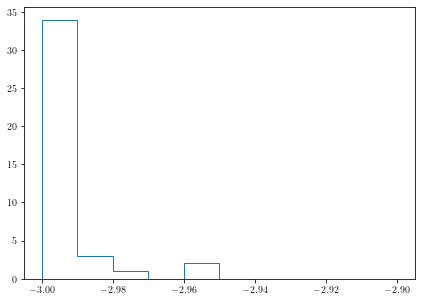

In [13]:
nrows,ncols=1,1
fig,ax = plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

U = np.sort(U)
print(U[U<-2.95])
counts,edges = np.histogram(U,bins=10,range=(-3,-2.9))
ax.stairs(counts,edges)

plt.show()

# Method 2

In [ ]:
h = 0.2
L = 2**(1/6)
N = 2
P = L*np.random.uniform(size=(N,2))
max_iter = 100000

configs,U = minimize(P,h,max_iter=max_iter,track=True)

In [ ]:
nrows,ncols=1,2
fig,ax=plt.subplots(nrows=nrows,ncols=ncols,figsize=(7*ncols,5*nrows))

x,y = configs[0].T
ax[0].scatter(x,y,marker='o',s=75,lw=2,color='None',edgecolor='k')

x,y = configs[-1].T
ax[0].scatter(x,y,marker='o',s=75,lw=2,color='None',edgecolor='r')

ax[0].set_xlabel(r'$x$',size=30)
ax[0].set_ylabel(r'$y$',size=30)

scale = 1.05*np.amax(np.abs(configs))
ax[0].set_xlim(-scale,scale)
ax[0].set_ylim(-scale,scale)

ax[1].plot(U)
ax[1].set_xlabel(r'$\rm iteration$',size=30)
ax[1].set_ylabel(r'$U$',size=30)
ax[1].set_ylim(np.amin(U),0)

for i in range(2):
    ax[i].tick_params(axis='both',which='major',direction='in',labelsize=20)

plt.tight_layout()
plt.show()